In [25]:
from keras import backend as K
K.set_image_dim_ordering('tf')

import keras
print (keras.__version__, keras.backend.backend())

import tensorflow as tf
tf.python.control_flow_ops = tf

1.0.7 tensorflow


In [35]:
%matplotlib inline
import glob

from keras.models import Sequential, model_from_json
from keras.layers import Activation, Conv2D, Dense, Dropout,  Flatten
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from IPython.display import display
from IPython.display import (
    display_pretty, display_html, display_jpeg,
    display_png, display_json, display_latex, display_svg
)
from IPython.display import Image
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import os
import pickle

from skimage import io, color, feature, transform

In [29]:
IMAGE_SIZE = 100
NUM_IMAGES = 25000
BATCH_SIZE = 16

In [32]:
def preprocess_images():
    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)

    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
            '/data/smannan/train/train/',  # this is the target directory
            target_size=(150, 150),  # all images will be resized to 150x150
            batch_size=BATCH_SIZE,
            class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels
    
    # this is a similar generator, for validation data
    validation_generator = test_datagen.flow_from_directory(
            '/data/smannan/train/validation/',
            target_size=(150, 150),
            batch_size=BATCH_SIZE,
            class_mode='categorical')

    return (train_generator, validation_generator)

# Introduction

This project was designed to classify images of dogs and cats. The two methods implemented were Random Forests using scikit-learn and Convolutional Nueral Networks using Keras. The documentation for scikit-learn random forests can be found here: http://scikit-learn.org/stable/ and for Keras: https://keras.io/. The dataset consists 25,000 images of cats and dogs.

# Motivation

# Import and Tidy

Images were loaded as 100x100 greyscale numpy arrays for scitkit-learn and fed into a Keras convolutional nueral net using generators.

# Exploratory Data Analysis

Images were converted to 100x100 greyscaled numpy arrays to be used in Principal Component Analysis (PCA) and random forests. Below are a few of the processed images.

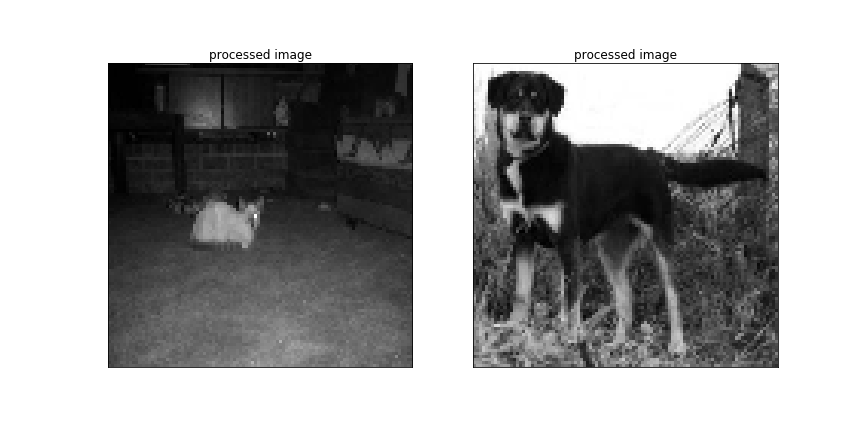

In [3]:
Image(filename='output/processed_images.png', embed=True, width=800, height=800)

Principal Component Analysis (PCA) is used to analyze the relationship between cat and dog images in two and three dimensions. By using PCA to reduce the dimensions, the relationship between the different images becomes clearer and easier to visualize.

Looking at the raw processed images, a clear distinction between cats and dogs is not clear. 

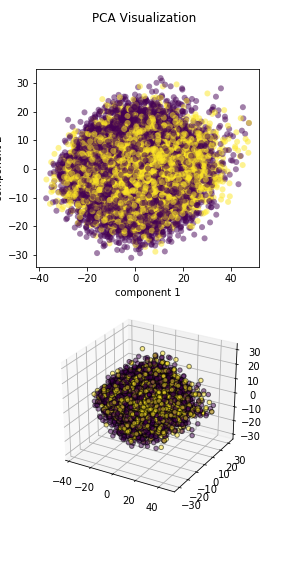

In [4]:
Image(filename='output/pca.png', embed=True, width=400, height=400)

# Feature Extraction

Histogram of Oriented Gradients (HOG) features were extracted from each image to reduce the feature dimensions. By describing local appearances and shapes within an image with edge directions, the features become more robust to noise.

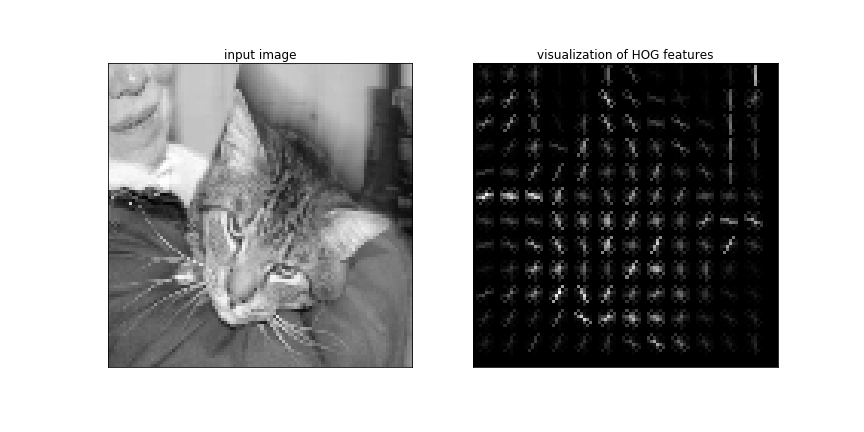

In [5]:
Image(filename='output/hog_visual.png', embed=True, width=800, height=800)

I ran PCA on the HOG features in order to visualize them in two and three-dimensional space. There appears to be a clearer distinction between cats and dogs after extracting HOG features from the images.

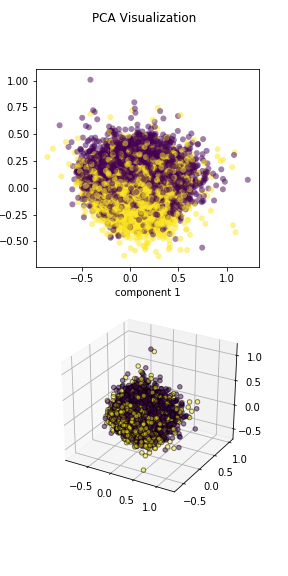

In [6]:
Image(filename='output/hog_pca.png', embed=True, width=400, height=400)

# Random Forests

After cleaning the data and extracting key features, I moved on to a random forest classifier to predict which images would be cats or dogs. Both HOG and PCA feautres were used and gave the same performance. A grid search over the number of estimators using a five-fold cross validation was used to find the best model. A five-fold cross validation with a 70/30 training/testing split was used to train and test the model. Performance was evalutated using Receiver Operating Characteristic (ROC) curves, binary accuracy, and log loss. 

ROC visualizes the tradeoff between true positive and false positive rate. A perfect curve would make a right angle with the upper left corner. The more images you correctly classify as dogs the more cat images you may incorrectly classify as dogs. 

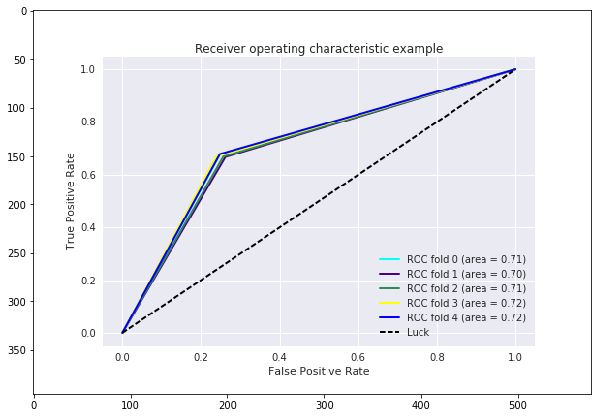

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('output/hog_features.png'));

The averaged log loss of the random forest over five folds was 0.69 with an average accuracy of 71.088%. Accuracy is measured as percentage of dog images that were correctly predicted. 

In [9]:
logloss = pickle.load(open('/home/smannan/finalproject/random_forest_logloss.p', 'rb'))
acc = pickle.load(open('/home/smannan/finalproject/random_forest_acc.p', 'rb'))
print ('LOG LOSS', np.mean(logloss), 'ACCURACY', np.mean(acc))

LOG LOSS 0.69314718056 ACCURACY 0.71088


# Convolutional Nueral Nets

Neural nets take in pixel arrays and output class probabilities. They provide a way to look at low-level features such as edges and curves then build them up to more abstract ones via convoloutional layers. 

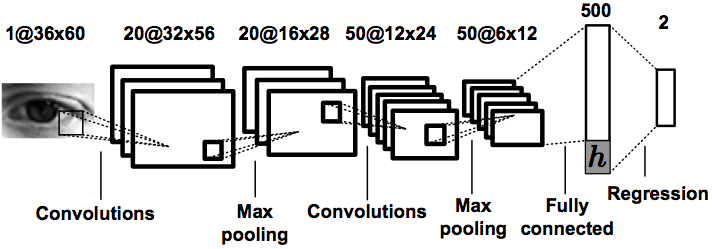

In [10]:
Image(filename='output/cnnModel.png', embed=True)

Each block in this model contained a convolution, activation, and max pooling layer. The model contained three blocks and a fully connected layer. The model trained on 50 epochs with a batch size of 16.

Before applying the model to the dataset, some image preprocessing was done to improve performance. Tried different rotations and tilts to augment the dataset so that the model would be able to recognize different types of cat pictures as cats.

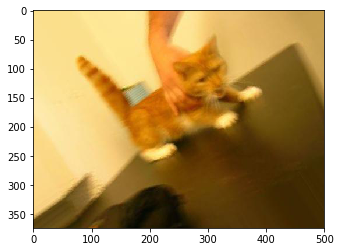

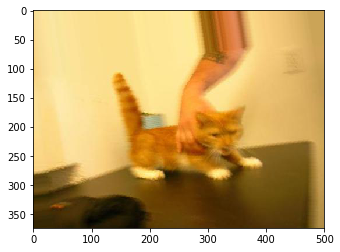

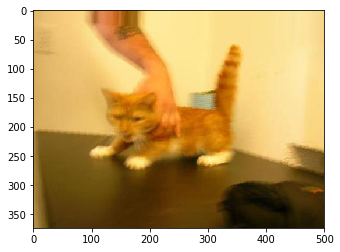

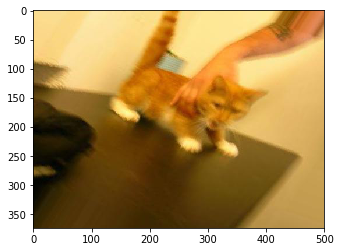

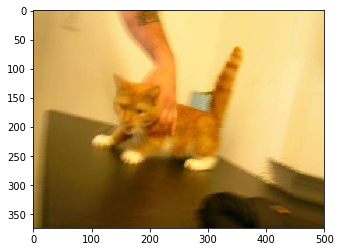

In [19]:
os.chdir('/home/smannan/finalproject/output/preview/')
files = glob.glob('*.jpeg')
fig = plt.figure()
fig.subplots_adjust(hspace=1.0, wspace=0.8)

for f in files[:5]:
    plt.imshow(mpimg.imread('/home/smannan/finalproject/output/preview/' + f))
    plt.show();

After image preprocessing, the model was finally ready to be trained. A 70/30% training/testing split was used. There were 8500 cats and dogs used for training and 3,750 cats and dogs used for testing. The model reached a loss of 0.49 and an accuracy of 77.25%

# Demo

In [22]:
def load_model(model_arch, model_weights):
    json_file = open(model_arch, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    
    # load weights into new model
    loaded_model.load_weights(model_weights)
    print("Loaded model from disk")
    
    return (loaded_model) 

In [33]:
_, validation_generator = preprocess_images()
loaded_model = load_model('/home/smannan/finalproject/models/model.json', 
                          '/home/smannan/finalproject/models/model_preprocessed_images.h5')

loaded_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
score = loaded_model.evaluate_generator(validation_generator, val_samples=2000)
score

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Loaded model from disk


[0.49792174792289734, 0.76949999999999996]

11/11 [==============================] - 0s


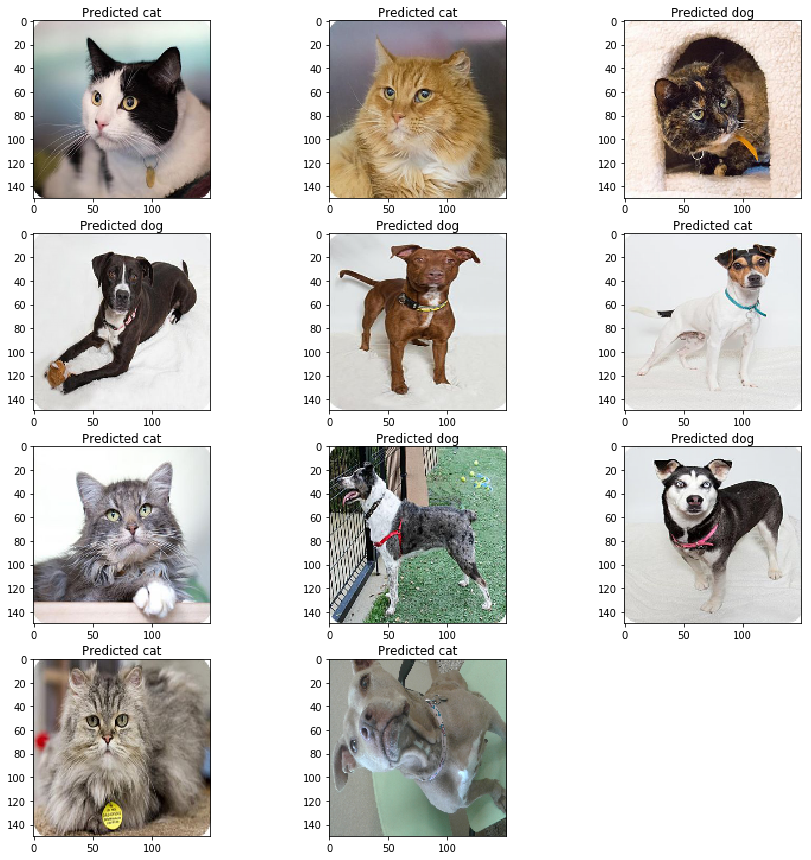

In [45]:
os.chdir('/home/smannan/finalproject/test/')
files = glob.glob('*.jpg')
test_im = []
for im in files:
    test_im.append(transform.resize(io.imread(im), (150, 150)))
test_im = np.reshape(np.array(test_im), (len(test_im), 150, 150, 3))
classes = loaded_model.predict_classes(test_im)
labels = ['cat', 'dog']

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
i = 1
for im, pred in zip(test_im, classes):
    ax1 = fig.add_subplot(4,3,i)
    ax1.imshow(im)
    plt.title('Predicted ' + labels[pred])
    i += 1
plt.show();

# Conclusion

Next steps would be to continue to improve the accuracy of these models, to classify different breeds (and perhaps mixed breeds or mutts), or to try videos of cats and dogs next. 

# Work Cited

1. https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/
2. https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
3. http://machinelearningmastery.com/
4. https://keras.io/
5. http://scikit-learn.org/stable/documentation.html
6. https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
7. https://www.youtube.com/user/sentdex